Contrafactual usando KDTree para encontrar a onda mais próxima na nova idade

In [1]:
import os, sys

sys.path.append('..' + os.sep + 'preprocess2')

from common import*

from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

FilterNeurokitWarnings()

In [9]:
BEG_TRAIN = '../preprocess2/' + PREPROCESSED_DATA + '/0/'
BEG_TEST = '..' + os.sep + 'data' + os.sep + 'TestData' + os.sep

In [29]:
dfAgeSex = pd.read_csv(BEG_TEST + 'attributes.csv')
dfLabels = pd.read_csv(BEG_TEST + 'annotations/gold_standard.csv')
with h5py.File(BEG_TEST + 'ecg_tracings.hdf5') as f:
    M = np.array(f['tracings'])

In [30]:
dfLabels = dfLabels.values
dfLabels[:,-1], dfLabels[:,-2] = dfLabels[:,-2], dfLabels[:,-1].copy()

In [41]:
idxAF = []
for i in range(len(dfLabels)):
    row = dfLabels[i]
    if np.all(row == [0] * 5 + [1]):
        idxAF.append(i)
idxAF

[120, 170, 259, 348, 355, 368, 408, 501, 548, 564, 572]

55


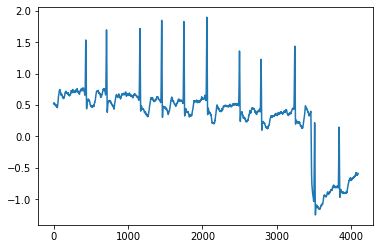

In [48]:
def GetTestAge(i):
    return dfAgeSex.values[i][0]
pessoa = 170
ecg = M[pessoa, :, ELETRODO_IDX]
age = GetTestAge(pessoa)
print(age)
plt.plot(ecg)

In [43]:
targetAge = 70

start = BEG_TRAIN + str(targetAge) + os.sep

mappings = np.load(start + 'mappings.npy')
ecgs = np.load(start + 'ecgs.npy')
ondas = np.load(start + 'ondas.npy')
labels = np.load(start + 'labels.npy')

In [44]:
tree = KDTree(ondas)

In [45]:
def GetTestCoeffs(ecg):
    w = ecg - ecg.mean()
    try:
        d = nk.ecg_delineate(w, sampling_rate=SAMPLE_RATE)[1]
    except:
        raise Exception('Neurokit não conseguiu delinear esse ECG')

    starts = d['ECG_P_Onsets']
    coeffs = []
    for j in range(len(starts) - 1):
        cur = starts[j]
        nxt = starts[j + 1]
        if math.isnan(cur) or math.isnan(nxt):
            print('Neurokit retornou nan')
            continue
            
        period = w[cur:nxt]
        if not len(period):
            print('Neurokit retornou período vazio')
            break
            
        coeffs.append(GetCoeff(period))

    if not len(coeffs):
        raise Exception('Neurokit não conseguiu encontrar batimentos nesse ECG')
        
    return coeffs

In [49]:
coeffs = GetTestCoeffs(ecg)

[0 0 0 0 0 1]
[0 0 0 0 0 0]


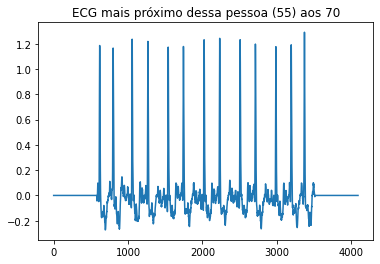

In [50]:
dist, ind = tree.query(coeffs)
gIdx = dist.argmin()
idxClosestOnda = ind[gIdx][0]
ecgOrgRow = mappings[idxClosestOnda]
ecgClosest = ecgs[ecgOrgRow]
plt.plot(ecgClosest)
print(dfLabels[pessoa])
plt.title('ECG mais próximo dessa pessoa (' + str(age) + ') aos ' + str(targetAge))
print(labels[ecgOrgRow].astype(int))
plt.show()